<a href="https://colab.research.google.com/github/osiriszjq/impulse_init/blob/main/Impulse_Initialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impulse Initialization

This notebook showcases [impulse initialization]() of Vision Transformers (ViT). We also provide some simple code of [mimetic initialization](https://arxiv.org/abs/2305.09828) for comparision. The baseline model is modified [Simple ViT](https://arxiv.org/abs/2205.01580).

The notebool is divided into following sections:
* [Simple ViT](#scrollTo=cDRlAKuYZqOg)
* [Mmodified Simple ViT Models](#scrollTo=-ImBjKzYuchD)
* [Impulse Initialization](#section_3)

## Section 0: Import Functions & Dataloader

---

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 828.9 kB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import  pyplot as plt

import os
import time
import argparse

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

parser = argparse.ArgumentParser()
args = parser.parse_args('')
print(args)

Namespace()


Preparing dataset

In [ ]:
#@markdown Choose dataset from `CIFAR-10`, `CIFAR-100`, `SVHN`, or edit the code to add your own dataset.
args.dataset = "cifar10" # @param ["cifar10", "cifar100", "svhn"]
#@markdown Chooose whether use data augmentation or not. You can edit the code to add your own data augmentation.
args.data_aug = True #@param{type:'boolean'}
#@markdown Other parameters, you can change as you need.
args.data_path = "./data" # @param{type:'string'}
args.batch_size = 256 # @param{type:'integer'}
args.num_workers = 2 # @param{type:'integer'}
args.pin_memory = True #@param{type:'boolean'}

print(f'==> Preparing {args.dataset} data..')
# Get imagne size, dataset mean & std.
# Image size and patch size will also be used in future model claim.
if args.dataset[:5] == 'cifar':
    args.image_size = 32
    args.patch_size = 2
    dataset_mean = (0.4914, 0.4822, 0.4465)
    dataset_std = (0.2471, 0.2435, 0.2616)
elif args.dataset == 'svhn':
    args.image_size = 32
    args.patch_size = 2
    dataset_mean = (0.4376821, 0.4437697, 0.47280442)
    dataset_std = (0.19803012, 0.20101562, 0.19703614)
else:
    print('no available dataset')
# Set data augmentation for train set.
if args.data_aug:
    train_transform = transforms.Compose([
        transforms.RandAugment(2, 14),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(args.image_size),
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
    ])
else:
    train_transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
    ])
test_transform = transforms.Compose([
    transforms.Resize(args.image_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std)
])
# Get train and test dataset.
# Need to specify number of classes for futrue model claim.
if args.dataset == 'cifar10':
    args.num_classes = 10
    train_dataset = torchvision.datasets.CIFAR10(root=args.data_path, train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(root=args.data_path, train=False, download=True, transform=test_transform)
elif args.dataset == 'cifar100':
    args.num_classes = 100
    train_dataset = torchvision.datasets.CIFAR100(root=args.data_path, train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR100(root=args.data_path, train=False, download=True, transform=test_transform)
elif args.dataset == 'svhn':
    args.num_classes = 10
    train_dataset = torchvision.datasets.SVHN(root=args.data_path, split='train', download=True, transform=train_transform)
    test_dataset = torchvision.datasets.SVHN(root=args.data_path, split='test', download=True, transform=test_transform)
else:
    print('no available dataset')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=args.pin_memory)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=args.pin_memory)

==> Preparing cifar10 data..


100%|██████████| 170498071/170498071 [00:03<00:00, 43654305.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Section 1: Simple ViT

---



Simple ViT is a better plain ViT baseline, which is more similar to ConvMixer architecture. Both of them are composed from input patch embedding, several layers of spatial mixing and channel mixing, and then pooling to an embedding for classification MLP on top.

![ConvMixer and Simple ViT](https://drive.google.com/uc?export=view&id=1Lyn6csP1Qk-S8vaqnuyKt1x2fiT-3o4o)

### code
Here is an implementation of Simple ViT.

In [ ]:
# from: https://github.com/kentaroy47/vision-transformers-cifar10/blob/main/models/simplevit.py
# from: https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/simple_vit.py

import torch
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(patches, temperature = 10000, dtype = torch.float32):
    _, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    y, x = torch.meshgrid(torch.arange(h, device = device), torch.arange(w, device = device), indexing = 'ij')
    assert (dim % 4) == 0, 'feature dimension must be multiple of 4 for sincos emb'
    omega = torch.arange(dim // 4, device = device) / (dim // 4 - 1)
    omega = 1. / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim = 1)
    return pe.type(dtype)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.to_latent = nn.Identity()
        self.linear_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        *_, h, w, dtype = *img.shape, img.dtype

        x = self.to_patch_embedding(img)
        pe = posemb_sincos_2d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        x = self.transformer(x)
        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return self.linear_head(x)

### Model & training settings

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 1e-4 # @param
args.num_epochs = 10 # @param{type:'integer'}

model = SimpleViT(
    image_size = args.image_size,
    patch_size = args.patch_size,
    num_classes = args.num_classes,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.num_epochs)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()
        with torch.cuda.amp.autocast(enabled=use_amp):
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    scheduler.step()
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

cuda
using data parallel
Namespace(dataset='cifar10', data_aug=True, data_path='./data', batch_size=256, num_workers=2, pin_memory=True, image_size=32, patch_size=2, num_classes=10, lr=0.0001, num_epochs=10)
epoch:  0, train_loss: 2.1241, train_acc: 0.2130, val_acc: 0.3227, lr: 9.755E-05, epoch_time: 132.6
epoch:  1, train_loss: 1.8866, train_acc: 0.3109, val_acc: 0.4673, lr: 9.045E-05, epoch_time: 133.0
epoch:  2, train_loss: 1.7327, train_acc: 0.3709, val_acc: 0.5210, lr: 7.939E-05, epoch_time: 133.1
epoch:  3, train_loss: 1.6371, train_acc: 0.4092, val_acc: 0.5574, lr: 6.545E-05, epoch_time: 132.9
epoch:  4, train_loss: 1.5631, train_acc: 0.4403, val_acc: 0.5727, lr: 5.000E-05, epoch_time: 133.5
epoch:  5, train_loss: 1.4941, train_acc: 0.4658, val_acc: 0.5972, lr: 3.455E-05, epoch_time: 133.1
epoch:  6, train_loss: 1.4413, train_acc: 0.4879, val_acc: 0.6164, lr: 2.061E-05, epoch_time: 134.0
epoch:  7, train_loss: 1.3972, train_acc: 0.5014, val_acc: 0.6343, lr: 9.549E-06, epoch_time

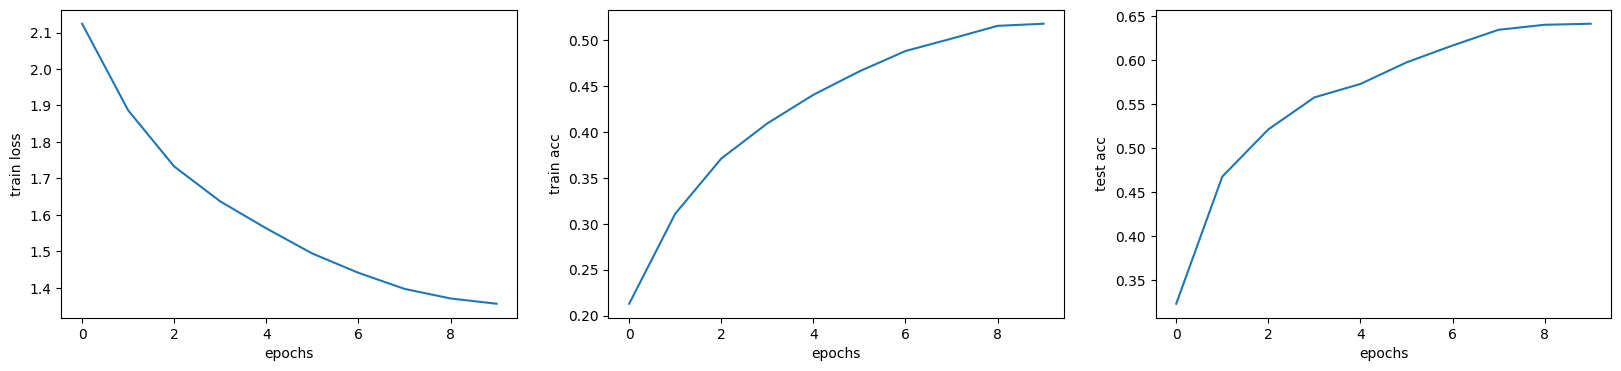

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

## Section 2: Modified Simple ViT Models


---


The Simple ViT model is already very similar to ConvMixer in many aspects. The only difference is the spatial mixing part (attention for Simple ViT while convolution for ConvMixer). To make this relationship more clear and have a better understanding, we build a series of modified Simple ViT models by changing the inputs and weights of Q, K & V. You can see how Simple ViT turns into ConvMixer step by step.
![Attention](https://drive.google.com/uc?export=view&id=1eaq-JKvvu2jRAtRtHlBh47MuwsydBa2O)

### code

Our implementation is based on the Simple ViT code above. Runing this cell will overwrite the functions for Simple ViT. You can still get the original Simple ViT model by specifying arguments.

In [ ]:
from einops import rearrange
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(h, w, dim, temperature: int = 10000, dtype = torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim // 4) / (dim // 4 - 1)
    omega = 1.0 / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)


# my impulse initilization function
def impulse_init(heads,img_size,att_rank,ff,scale=1.0,spatial_pe=None,norm=1):
    weight = torch.zeros((heads,img_size**2,img_size**2))
    k = torch.randint(0,ff**2,(heads,))
    for i in range(heads):
        m = (k[i]//ff)-(ff//2)
        n = (k[i]%ff)-(ff//2)
        tmp_weight = torch.zeros((img_size,img_size))
        for j in range(0-min(0,n),img_size-max(0,n)):
            tmp_weight[j,j+n] = 1
        for j in range(0-min(0,m),img_size-max(0,m)):
            weight[i,j*img_size:(j+1)*img_size,(j+m)*img_size:(j+m+1)*img_size] = tmp_weight
    # weight = np.sqrt(1/3)*weight
    class PermuteM(nn.Module):
        def __init__(self, heads, img_size, att_rank,scale=1.0,spatial_pe=None):
            super().__init__()
            self.scale = scale
            if spatial_pe is None:
                self.spatial_pe = False
                weights_Q = np.sqrt(1/att_rank/heads)*(2*torch.rand(heads,img_size,att_rank)-1)
                weights_K = np.sqrt(1/att_rank/heads)*(2*torch.rand(heads,att_rank,img_size)-1)
            else:
                self.spatial_pe = True
                self.pe = spatial_pe.cuda()
                weights_Q = np.sqrt(1/att_rank/heads)*(2*torch.rand(heads,spatial_pe.shape[1],att_rank)-1)
                weights_K = np.sqrt(1/att_rank/heads)*(2*torch.rand(heads, att_rank, spatial_pe.shape[1])-1)

            self.weights_K = nn.Parameter(weights_K)
            self.weights_Q = nn.Parameter(weights_Q)
        def forward(self):
            if self.spatial_pe:
                M = self.pe@self.weights_Q@self.weights_K@(self.pe.T)
            else:
                M = torch.bmm(self.weights_Q,self.weights_K)
            return torch.softmax(M*self.scale,-1)

    net = PermuteM(heads,img_size**2,att_rank,scale,spatial_pe)
    net.cuda()

    nq = net.weights_Q.detach().cpu().norm(dim=(1)).mean()
    weight = weight.cuda()
    num_epoch = 10000
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)#,weight_decay=1e-6)
    for i in range(num_epoch):
        if i%norm==0:
            with torch.no_grad():
                net.weights_Q.div_(net.weights_Q.detach().norm(dim=(1),keepdim=True)/nq)
                net.weights_K.div_(net.weights_K.detach().norm(dim=(1),keepdim=True)/nq)
        optimizer.zero_grad()
        outputs = net()
        loss = criterion(outputs, weight)
        loss.backward()
        optimizer.step()
    print(loss.data)

    return net.weights_Q.detach().cpu(),net.weights_K.detach().cpu()

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, use_value = True, spatial_pe = None,
                 spatial_x = True, init = 'none', alpha=1.0, trainable=True, out_layer=True):
        super().__init__()
        inner_dim = dim_head *  heads
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)

        self.alpha = alpha

        # input to q&k
        self.spatial_x = spatial_x
        self.spatial_pe = False
        if spatial_pe is not None:
            self.spatial_pe = True
            self.pos_embedding = spatial_pe

        # format & initilization of q&k
        self.init = init
        if init == 'none':
            self.to_qk = nn.Linear(dim, inner_dim*2, bias = False)
        else:
            if init[:7] == 'impulse':
                a, b, c, d, e = init[7:].split('_')
                img_size = int(a)
                att_rank = int(b)
                ff = int(c)
                self.scale = float(d)
                norm = int(e)
                Q, K = impulse_init(heads,img_size,att_rank,ff,self.scale,spatial_pe,norm)
            elif init[:6] == 'random':
                a, b = init[6:].split('_')
                img_size = int(a)
                att_rank = int(b)
                Q = np.sqrt(1/img_size)*(2*torch.rand(heads,img_size,att_rank)-1)
                K = np.sqrt(1/img_size)*(2*torch.rand(heads,att_rank,img_size)-1)

            elif init[:7] == 'mimetic':
                a, b = init[7:].split('_')
                img_size = int(a)
                att_rank = int(b)
                W = 0.7*np.sqrt(1/img_size)*(2*torch.rand(heads,img_size,img_size)-1)+0.7*torch.eye(img_size).unsqueeze(0).repeat(heads,1,1)
                U,s,V = torch.linalg.svd(W)
                s_2 = torch.sqrt(s)
                Q = torch.matmul(U[:,:,:att_rank], torch.diag_embed(s_2)[:,:att_rank,:att_rank])
                K = torch.matmul(torch.diag_embed(s_2)[:,:att_rank,:att_rank], V[:,:att_rank,:])
            if self.spatial_pe|self.spatial_x:
                print('use linear format')
                self.to_qk = nn.Linear(dim, inner_dim*2, bias = False)
                self.to_qk.weight.data[:512,:] = rearrange(Q, 'h n d -> n (h d)').T
                self.to_qk.weight.data[512:,:] = rearrange(K, 'h d n -> n (h d)').T
            else:
                print('use Q K format')
                self.Q = nn.Parameter(Q,requires_grad=trainable)
                self.K = nn.Parameter(K,requires_grad=trainable)

        # use v or just use x
        self.use_value = use_value
        if use_value:
            self.to_v = nn.Linear(dim, inner_dim, bias = False)

        # use output layer or not
        self.out_layer = out_layer
        if self.out_layer:
            self.to_out = nn.Linear(inner_dim, dim, bias = False)



    def forward(self, x):
        x = self.norm(x)

        # use v or just use x
        if self.use_value:
            v = self.to_v(x)
        else:
            v = x

        # q&k format
        if self.spatial_pe|self.spatial_x:
            # input to q&v
            device = x.device
            if self.spatial_pe&self.spatial_x:
                x = self.alpha*x + (1-self.alpha)*self.pos_embedding.to(device, dtype=x.dtype)
            elif self.spatial_pe:
                x = 0*x + self.pos_embedding.to(device, dtype=x.dtype)
            qk = self.to_qk(x).chunk(2, dim = -1)
            q, k = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qk)
            dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        else:
            dots = torch.matmul(self.Q, self.K) * self.scale
        attn = self.attend(dots)

        out = torch.matmul(attn, rearrange(v, 'b n (h d) -> b h n d', h = self.heads))
        out = rearrange(out, 'b h n d -> b n (h d)')
        if self.out_layer:
            return self.to_out(out)
        else:
            return out



class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, use_value=True, spatial_pe=None, spatial_x = True, init = 'none', alpha=1.0, trainable=False):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads, dim_head, use_value, spatial_pe, spatial_x, init, alpha, trainable),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class SimpleViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64,
                 input_pe = True, pe_choice='sin', use_value = True, spatial_pe = False, spatial_x = True, init = 'none', alpha=0.5, trainable=False):
        super().__init__()

        self.input_pe = input_pe
        self.use_value = use_value
        self.alpha = alpha
        if input_pe: alpha_inside = 1.0
        else: alpha_inside = alpha

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        if pe_choice == 'sin':
            self.pos_embedding = posemb_sincos_2d(
                h = image_height // patch_height,
                w = image_width // patch_width,
                dim = dim,
            )
        elif pe_choice == 'identity':
            # self.pos_embedding = torch.eye(64).repeat(1,8).type(torch.float32)
            s = (image_height // patch_height)*(image_width // patch_width)
            self.pos_embedding = torch.cat([torch.eye(s),torch.zeros(s,dim-s)],dim=-1).type(torch.float32)
        if spatial_pe:
            self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, use_value, self.pos_embedding, spatial_x, init, alpha_inside, trainable)
        else: # change dim_heads here
            self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, use_value, None, spatial_x, init, alpha_inside, trainable)

        self.pool = "mean"
        self.to_latent = nn.Identity()

        self.linear_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        device = img.device

        x = self.to_patch_embedding(img)
        if self.input_pe:
            x = self.alpha*x + (1-self.alpha)*self.pos_embedding.to(device, dtype=x.dtype)

        x = self.transformer(x)
        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return self.linear_head(x)

### original model

![original](https://drive.google.com/uc?export=view&id=1HWYGgGcUy90VZTi3W5CHKE9gf8DvSpR-)

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 1e-4 # @param
args.num_epochs = 10 # @param{type:'integer'}

model = SimpleViT(
    image_size = args.image_size,
    patch_size = args.patch_size,
    num_classes = args.num_classes,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    input_pe = True, # set False to not use input positional encoding
    use_value = True, # set False to not use value MLP
    spatial_pe = False,
    spatial_x = True,
    init = 'none',
    trainable = True)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.num_epochs)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()
        with torch.cuda.amp.autocast(enabled=use_amp):
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    scheduler.step()
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

### model I

![model I](https://drive.google.com/uc?export=view&id=1ljNqmn4dC9SBVrupT5rDsSwIqugnd9pN)

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 1e-4 # @param
args.num_epochs = 10 # @param{type:'integer'}

model = SimpleViT(
    image_size = args.image_size,
    patch_size = args.patch_size,
    num_classes = args.num_classes,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    input_pe = False,
    use_value = True, # set False to not use value MLP
    spatial_pe = True,
    spatial_x = True,
    init = 'none',
    trainable = True)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.num_epochs)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()
        with torch.cuda.amp.autocast(enabled=use_amp):
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    scheduler.step()
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

### model II

![model II](https://drive.google.com/uc?export=view&id=1Q4oM43g-DciMbm3jQzEbMxKM-MA_htfo)

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 1e-4 # @param
args.num_epochs = 10 # @param{type:'integer'}

model = SimpleViT(
    image_size = args.image_size,
    patch_size = args.patch_size,
    num_classes = args.num_classes,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    input_pe = False,
    use_value = True, # set False to not use value MLP
    spatial_pe = True,
    spatial_x = True,
    init = 'none',
    trainable = True)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.num_epochs)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()
        with torch.cuda.amp.autocast(enabled=use_amp):
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    scheduler.step()
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

### model III

![model III](https://drive.google.com/uc?export=view&id=1n1q8fD0yDGAaksqmaCnu07H1FtgGq98H)

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 1e-4 # @param
args.num_epochs = 10 # @param{type:'integer'}

model = SimpleViT(
    image_size = args.image_size,
    patch_size = args.patch_size,
    num_classes = args.num_classes,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    input_pe = False,
    use_value = True, # set False to not use value MLP
    spatial_pe = False,
    spatial_x = False,
    init = 'none',
    trainable = True)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.num_epochs)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
train_losses = []
train_acces = []
test_acces = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()
        with torch.cuda.amp.autocast(enabled=use_amp):
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces.append(test_acc)
    scheduler.step()
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

## Sction3: Impulse Initialization

---

Based on the relation in section 2, we proposed to use convolution filters as initialization of attention maps. To be more specific, initialize the weights of Q&K such that with positional encoding input, the attention map after SoftMax is in covolution impulse filter format.

![init](https://drive.google.com/uc?export=view&id=1uQx6PDDsd2QqQ4X7jF82VewTOL1xyQ5y)

### code

Same code as in section 2. In case someone didn't run this in section 2.

In [ ]:
from einops import rearrange
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(h, w, dim, temperature: int = 10000, dtype = torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim // 4) / (dim // 4 - 1)
    omega = 1.0 / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)


# my impulse initilization function
def impulse_init(heads,img_size,att_rank,ff,scale=1.0,spatial_pe=None,norm=1):
    weight = torch.zeros((heads,img_size**2,img_size**2))
    k = torch.randint(0,ff**2,(heads,))
    for i in range(heads):
        m = (k[i]//ff)-(ff//2)
        n = (k[i]%ff)-(ff//2)
        tmp_weight = torch.zeros((img_size,img_size))
        for j in range(0-min(0,n),img_size-max(0,n)):
            tmp_weight[j,j+n] = 1
        for j in range(0-min(0,m),img_size-max(0,m)):
            weight[i,j*img_size:(j+1)*img_size,(j+m)*img_size:(j+m+1)*img_size] = tmp_weight
    # weight = np.sqrt(1/3)*weight
    class PermuteM(nn.Module):
        def __init__(self, heads, img_size, att_rank,scale=1.0,spatial_pe=None):
            super().__init__()
            self.scale = scale
            if spatial_pe is None:
                self.spatial_pe = False
                weights_Q = np.sqrt(1/att_rank/heads)*(2*torch.rand(heads,img_size,att_rank)-1)
                weights_K = np.sqrt(1/att_rank/heads)*(2*torch.rand(heads,att_rank,img_size)-1)
            else:
                self.spatial_pe = True
                self.pe = spatial_pe.cuda()
                weights_Q = np.sqrt(1/att_rank/heads)*(2*torch.rand(heads,spatial_pe.shape[1],att_rank)-1)
                weights_K = np.sqrt(1/att_rank/heads)*(2*torch.rand(heads, att_rank, spatial_pe.shape[1])-1)

            self.weights_K = nn.Parameter(weights_K)
            self.weights_Q = nn.Parameter(weights_Q)
        def forward(self):
            if self.spatial_pe:
                M = self.pe@self.weights_Q@self.weights_K@(self.pe.T)
            else:
                M = torch.bmm(self.weights_Q,self.weights_K)
            return torch.softmax(M*self.scale,-1)

    net = PermuteM(heads,img_size**2,att_rank,scale,spatial_pe)
    net.cuda()

    nq = net.weights_Q.detach().cpu().norm(dim=(1)).mean()
    weight = weight.cuda()
    num_epoch = 10000
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)#,weight_decay=1e-6)
    for i in range(num_epoch):
        if i%norm==0:
            with torch.no_grad():
                net.weights_Q.div_(net.weights_Q.detach().norm(dim=(1),keepdim=True)/nq)
                net.weights_K.div_(net.weights_K.detach().norm(dim=(1),keepdim=True)/nq)
        optimizer.zero_grad()
        outputs = net()
        loss = criterion(outputs, weight)
        loss.backward()
        optimizer.step()
    print(loss.data)

    return net.weights_Q.detach().cpu(),net.weights_K.detach().cpu()

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, use_value = True, spatial_pe = None,
                 spatial_x = True, init = 'none', alpha=1.0, trainable=True, out_layer=True):
        super().__init__()
        inner_dim = dim_head *  heads
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)

        self.alpha = alpha

        # input to q&k
        self.spatial_x = spatial_x
        self.spatial_pe = False
        if spatial_pe is not None:
            self.spatial_pe = True
            self.pos_embedding = spatial_pe

        # format & initilization of q&k
        self.init = init
        if init == 'none':
            self.to_qk = nn.Linear(dim, inner_dim*2, bias = False)
        else:
            if init[:7] == 'impulse':
                a, b, c, d, e = init[7:].split('_')
                img_size = int(a)
                att_rank = int(b)
                ff = int(c)
                self.scale = float(d)
                norm = int(e)
                Q, K = impulse_init(heads,img_size,att_rank,ff,self.scale,spatial_pe,norm)
            elif init[:6] == 'random':
                a, b = init[6:].split('_')
                img_size = int(a)
                att_rank = int(b)
                Q = np.sqrt(1/img_size)*(2*torch.rand(heads,img_size,att_rank)-1)
                K = np.sqrt(1/img_size)*(2*torch.rand(heads,att_rank,img_size)-1)

            elif init[:7] == 'mimetic':
                a, b = init[7:].split('_')
                img_size = int(a)
                att_rank = int(b)
                W = 0.7*np.sqrt(1/img_size)*(2*torch.rand(heads,img_size,img_size)-1)+0.7*torch.eye(img_size).unsqueeze(0).repeat(heads,1,1)
                U,s,V = torch.linalg.svd(W)
                s_2 = torch.sqrt(s)
                Q = torch.matmul(U[:,:,:att_rank], torch.diag_embed(s_2)[:,:att_rank,:att_rank])
                K = torch.matmul(torch.diag_embed(s_2)[:,:att_rank,:att_rank], V[:,:att_rank,:])
            if self.spatial_pe|self.spatial_x:
                print('use linear format')
                self.to_qk = nn.Linear(dim, inner_dim*2, bias = False)
                self.to_qk.weight.data[:512,:] = rearrange(Q, 'h n d -> n (h d)').T
                self.to_qk.weight.data[512:,:] = rearrange(K, 'h d n -> n (h d)').T
            else:
                print('use Q K format')
                self.Q = nn.Parameter(Q,requires_grad=trainable)
                self.K = nn.Parameter(K,requires_grad=trainable)

        # use v or just use x
        self.use_value = use_value
        if use_value:
            self.to_v = nn.Linear(dim, inner_dim, bias = False)

        # use output layer or not
        self.out_layer = out_layer
        if self.out_layer:
            self.to_out = nn.Linear(inner_dim, dim, bias = False)



    def forward(self, x):
        x = self.norm(x)

        # use v or just use x
        if self.use_value:
            v = self.to_v(x)
        else:
            v = x

        # q&k format
        if self.spatial_pe|self.spatial_x:
            # input to q&v
            device = x.device
            if self.spatial_pe&self.spatial_x:
                x = self.alpha*x + (1-self.alpha)*self.pos_embedding.to(device, dtype=x.dtype)
            elif self.spatial_pe:
                x = 0*x + self.pos_embedding.to(device, dtype=x.dtype)
            qk = self.to_qk(x).chunk(2, dim = -1)
            q, k = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qk)
            dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        else:
            dots = torch.matmul(self.Q, self.K) * self.scale
        attn = self.attend(dots)

        out = torch.matmul(attn, rearrange(v, 'b n (h d) -> b h n d', h = self.heads))
        out = rearrange(out, 'b h n d -> b n (h d)')
        if self.out_layer:
            return self.to_out(out)
        else:
            return out



class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, use_value=True, spatial_pe=None, spatial_x = True, init = 'none', alpha=1.0, trainable=False):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads, dim_head, use_value, spatial_pe, spatial_x, init, alpha, trainable),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class SimpleViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64,
                 input_pe = True, pe_choice='sin', use_value = True, spatial_pe = False, spatial_x = True, init = 'none', alpha=0.5, trainable=False):
        super().__init__()

        self.input_pe = input_pe
        self.use_value = use_value
        self.alpha = alpha
        if input_pe: alpha_inside = 1.0
        else: alpha_inside = alpha

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        if pe_choice == 'sin':
            self.pos_embedding = posemb_sincos_2d(
                h = image_height // patch_height,
                w = image_width // patch_width,
                dim = dim,
            )
        elif pe_choice == 'identity':
            # self.pos_embedding = torch.eye(64).repeat(1,8).type(torch.float32)
            s = (image_height // patch_height)*(image_width // patch_width)
            self.pos_embedding = torch.cat([torch.eye(s),torch.zeros(s,dim-s)],dim=-1).type(torch.float32)
        if spatial_pe:
            self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, use_value, self.pos_embedding, spatial_x, init, alpha_inside, trainable)
        else: # change dim_heads here
            self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, use_value, None, spatial_x, init, alpha_inside, trainable)

        self.pool = "mean"
        self.to_latent = nn.Identity()

        self.linear_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        device = img.device

        x = self.to_patch_embedding(img)
        if self.input_pe:
            x = self.alpha*x + (1-self.alpha)*self.pos_embedding.to(device, dtype=x.dtype)

        x = self.transformer(x)
        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return self.linear_head(x)

### impulse initialization

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 1e-4 # @param
args.num_epochs = 100 # @param{type:'integer'}

model = SimpleViT(
    image_size = args.image_size,
    patch_size = args.patch_size,
    num_classes = args.num_classes,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    input_pe = False,
    use_value = True,
    spatial_pe = True,
    spatial_x = True,
    init = 'impulse16_64_5_0.1_100',
    alpha = 0.2,
    trainable = True)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.num_epochs)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
train_losses = []
train_acces = []
test_acces_impulse = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()
        with torch.cuda.amp.autocast(enabled=use_amp):
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces_impulse.append(test_acc)
    scheduler.step()
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

tensor(0.0019, device='cuda:0')
use linear format
tensor(0.0019, device='cuda:0')
use linear format
tensor(0.0018, device='cuda:0')
use linear format
tensor(0.0018, device='cuda:0')
use linear format
tensor(0.0019, device='cuda:0')
use linear format
tensor(0.0019, device='cuda:0')
use linear format
cuda
using data parallel
Namespace(dataset='cifar10', data_aug=True, data_path='./data', batch_size=256, num_workers=2, pin_memory=True, image_size=32, patch_size=2, num_classes=10, lr=0.0001, num_epochs=100)
epoch:  0, train_loss: 1.9991, train_acc: 0.2616, val_acc: 0.4280, lr: 9.998E-05, epoch_time: 134.9
epoch:  1, train_loss: 1.7940, train_acc: 0.3506, val_acc: 0.4212, lr: 9.990E-05, epoch_time: 135.2
epoch:  2, train_loss: 1.6541, train_acc: 0.4082, val_acc: 0.5440, lr: 9.978E-05, epoch_time: 135.0
epoch:  3, train_loss: 1.5698, train_acc: 0.4396, val_acc: 0.5743, lr: 9.961E-05, epoch_time: 134.7
epoch:  4, train_loss: 1.4950, train_acc: 0.4700, val_acc: 0.5959, lr: 9.938E-05, epoch_tim

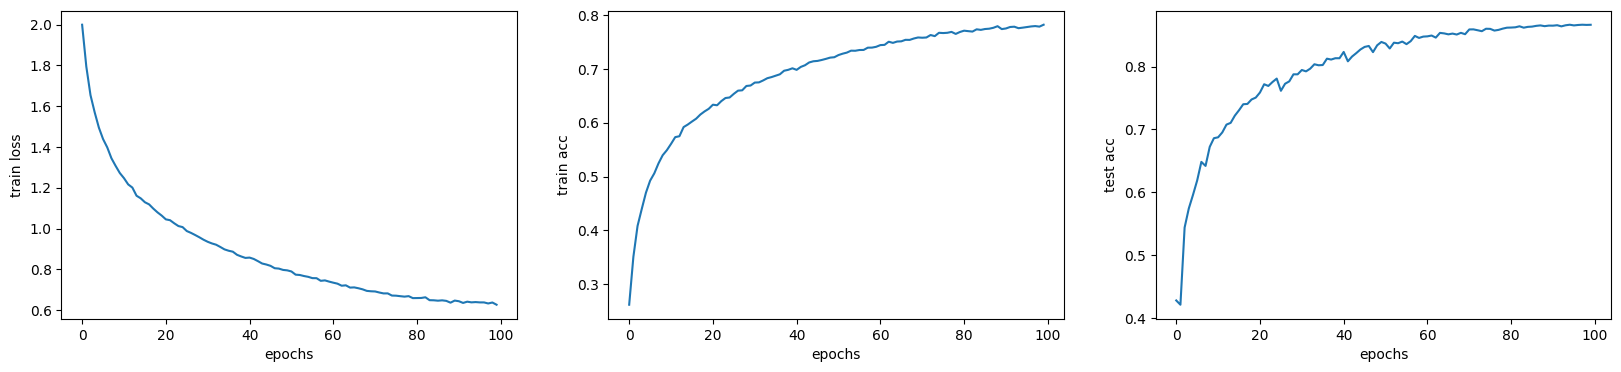

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces_impulse)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

### mimetic initialization

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 1e-4 # @param
args.num_epochs = 100 # @param{type:'integer'}

model = SimpleViT(
    image_size = args.image_size,
    patch_size = args.patch_size,
    num_classes = args.num_classes,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    input_pe = False,
    use_value = True,
    spatial_pe = True,
    spatial_x = True,
    init = 'mimetic512_64',
    alpha = 0.2,
    trainable = True)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.num_epochs)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
train_losses = []
train_acces = []
test_acces_mimetic = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()
        with torch.cuda.amp.autocast(enabled=use_amp):
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces_mimetic.append(test_acc)
    scheduler.step()
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

use linear format
use linear format
use linear format
use linear format
use linear format
use linear format
cuda
using data parallel
Namespace(dataset='cifar10', data_aug=True, data_path='./data', batch_size=256, num_workers=2, pin_memory=True, image_size=32, patch_size=2, num_classes=10, lr=0.0001, num_epochs=100)
epoch:  0, train_loss: 2.0348, train_acc: 0.2479, val_acc: 0.4005, lr: 9.998E-05, epoch_time: 134.7
epoch:  1, train_loss: 1.8359, train_acc: 0.3336, val_acc: 0.4431, lr: 9.990E-05, epoch_time: 134.6
epoch:  2, train_loss: 1.7297, train_acc: 0.3766, val_acc: 0.4970, lr: 9.978E-05, epoch_time: 135.0
epoch:  3, train_loss: 1.6573, train_acc: 0.4044, val_acc: 0.5245, lr: 9.961E-05, epoch_time: 134.8
epoch:  4, train_loss: 1.6000, train_acc: 0.4264, val_acc: 0.5419, lr: 9.938E-05, epoch_time: 134.8
epoch:  5, train_loss: 1.5435, train_acc: 0.4433, val_acc: 0.5522, lr: 9.911E-05, epoch_time: 134.7
epoch:  6, train_loss: 1.5036, train_acc: 0.4591, val_acc: 0.5748, lr: 9.880E-05, e

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces_mimetic)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

### comparision to baseline (random initialization)

In [ ]:
#@markdown Some model & training parameters, you can change as you need.
args.lr = 1e-4 # @param
args.num_epochs = 100 # @param{type:'integer'}

model = SimpleViT(
    image_size = args.image_size,
    patch_size = args.patch_size,
    num_classes = args.num_classes,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    input_pe = False,
    use_value = True,
    spatial_pe = True,
    spatial_x = True,
    init = 'random512_64',
    alpha = 0.2,
    trainable = True)

if 'cuda' in device:
    print(device)
    print("using data parallel")
    net = torch.nn.DataParallel(model) # make parallel
    cudnn.benchmark = True

optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.num_epochs)
print(args)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
train_losses = []
train_acces = []
test_acces_random = []
for epoch in range(args.num_epochs):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.cuda(), y.cuda()
        with torch.cuda.amp.autocast(enabled=use_amp):
            output = model(X)
            loss = criterion(output, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
    train_acc = train_acc/n
    train_loss = train_loss/n
    train_losses.append(train_loss)
    train_acces.append(train_acc)

    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)
    test_acc = test_acc/m
    test_acces_random.append(test_acc)
    scheduler.step()
    print(f'epoch: {epoch:2d}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {test_acc:.4f}, lr: {optimizer.param_groups[0]["lr"]:6.3E}, epoch_time: {time.time()-start:.1f}')

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.subplot(1,3,2)
plt.plot(train_acces)
plt.ylabel('train acc')
plt.xlabel('epochs')
plt.subplot(1,3,3)
plt.plot(test_acces_random)
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.show()

In [ ]:
plt.figure(figsize = (6,4))
plt.plot(test_acces_random, label='random')
plt.plot(test_acces_mimetic, label='mimetic')
plt.plot(test_acces_impulse, label='impulse')
plt.ylabel('test acc')
plt.xlabel('epochs')
plt.legend()
plt.show()